# Install Requirements

In [1]:
# !pip install nanopyx[jupyter]
# !pip install numba

## Necessary imports

In [2]:
import math
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt

from nanopyx import eSRRF
from tqdm import tqdm
from numba import njit, prange
from skimage import data
from skimage.morphology import binary_erosion
from skimage.transform import resize
from skimage.draw import line
from skimage.filters import threshold_mean as threshold_func
from scipy.signal import convolve2d
from nanopyx import eSRRF
from nanopyx.core.transform.sr_temporal_correlations import calculate_eSRRF_temporal_correlations
from nanopyx.methods.squirrel.error_map import calculate_error_map
from nanopyx import run_esrrf_parameter_sweep

# SMLM simulations

## Accessory functions

In [ ]:
# Multi-threaded Erf-based image construction
@njit(parallel=True)
def FromLoc2Image_MultiThreaded(
    xc_array: np.ndarray, yc_array: np.ndarray, photon_array: np.ndarray, sigma_array: np.ndarray, image_height: int, image_width: int
):
    """
    Generate an image from localized emitters using multi-threading.

    Parameters
    ----------
    xc_array : array_like
        Array of x-coordinates of the emitters.
    yc_array : array_like
        Array of y-coordinates of the emitters.
    photon_array : array_like
        Array of photon counts for each emitter.
    sigma_array : array_like
        Array of standard deviations (sigmas) for each emitter.
    image_height : int
        Height of the output image in pixels.
    image_width : int
        Width of the output image in pixels.

    Returns
    -------
    Image : ndarray
        2D array representing the generated image.

    Notes
    -----
    The function utilizes multi-threading for parallel processing using Numba's
    `njit` decorator with `parallel=True`. Emitters with non-positive photon
    counts or non-positive sigma values are ignored. Only emitters within a
    distance of 4 sigma from the center of the pixel are considered to save
    computation time.

    The calculation involves error functions (`erf`) to determine the contribution
    of each emitter to the pixel intensity.

    Originally from: https://colab.research.google.com/github/HenriquesLab/ZeroCostDL4Mic/blob/master/Colab_notebooks/Deep-STORM_2D_ZeroCostDL4Mic.ipynb
    """
    Image = np.zeros((image_height, image_width))
    for ij in prange(image_height * image_width):
        j = int(ij / image_width)
        i = ij - j * image_width
        for xc, yc, photon, sigma in zip(xc_array, yc_array, photon_array, sigma_array):
            # Don't bother if the emitter has photons <= 0 or if Sigma <= 0
            if (photon > 0) and (sigma > 0):
                S = sigma * math.sqrt(2)
                x = i - xc
                y = j - yc
                # Don't bother if the emitter is further than 4 sigma from the centre of the pixel
                if (x / 2) ** 2 + (
                    y / 2
                ) ** 2 < 16 * sigma**2:
                    ErfX = math.erf((x + 1.0) / S) - math.erf(x / S)
                    ErfY = math.erf((y + 1.0) / S) - math.erf(y / S)

                    Image[j][i] += 0.25 * photon * ErfX * ErfY
    return Image

def binary2locs(img: np.ndarray, density: float):
    """
    Selects a subset of locations from a binary image based on a specified density.

    Parameters
    ----------
    img : np.ndarray
        2D binary image array where 1s indicate points of interest.
    density : float
        Proportion of points to randomly select from the points of interest.
        Should be a value between 0 and 1.

    Returns
    -------
    filtered_locs : tuple of np.ndarray
        Tuple containing two arrays. The first array contains the row indices
        and the second array contains the column indices of the selected points.

    Notes
    -----
    The function identifies all locations in the binary image where the value is 1.
    It then randomly selects a subset of these locations based on the specified
    density and returns their coordinates.
    """
    all_locs = np.nonzero(img == 1)
    n_points = int(len(all_locs[0]) * density)
    selected_idx = np.random.choice(len(all_locs[0]), n_points, replace=False)
    filtered_locs = all_locs[0][selected_idx], all_locs[1][selected_idx]
    return filtered_locs

def createBranchingTree(width=5000, height=5000, lineWidth=3):
    np.random.seed(0)  # Set a random seed for reproducibility
    # Define the dimensions of the image
    width, height = width, height

    # Create a blank white image
    image = np.ones((height, width), dtype=np.uint8) * 255

    # Function to draw a line (blood vessel) on the image
    def draw_vessel(start, end, image):
        rr, cc = line(start[0], start[1], end[0], end[1])
        try:
            image[rr, cc] = 0  # Draw a black line
        except:
            end = 0
            return

    # Recursive function to draw a tree-like structure
    def draw_tree(start, angle, length, depth, image, reducer, max_angle=40):
        if depth == 0:
            return

        # Calculate the end point of the branch
        end = (
            int(start[0] + length * np.sin(np.radians(angle))),
            int(start[1] + length * np.cos(np.radians(angle))),
        )

        # Draw the branch
        draw_vessel(start, end, image)

        # change the angle slightly to add some randomness
        angle += np.random.uniform(-10, 10)

        # Recursively draw the next level of branches
        new_length = length * reducer  # Reduce the length for the next level
        new_depth = depth - 1
        draw_tree(
            end,
            angle - max_angle * np.random.uniform(-1, 1),
            new_length,
            new_depth,
            image,
            reducer,
        )
        draw_tree(
            end,
            angle + max_angle * np.random.uniform(-1, 1),
            new_length,
            new_depth,
            image,
            reducer,
        )

    # Starting point and parameters
    start_point = (height - 1, width // 2)
    initial_angle = -90  # Start by pointing upwards
    initial_length = np.max((width, height)) * 0.15  # Length of the first branch
    depth = 7  # Number of branching levels
    reducer = 0.9
    # Draw the tree structure
    draw_tree(start_point, initial_angle, initial_length, depth, image, reducer)

    # convolve image with rectangle
    rectangle = np.ones((lineWidth, lineWidth))
    image = convolve2d(image, rectangle, mode="same", boundary="fill", fillvalue=0)

    return image

## Generating a branching tree binary image

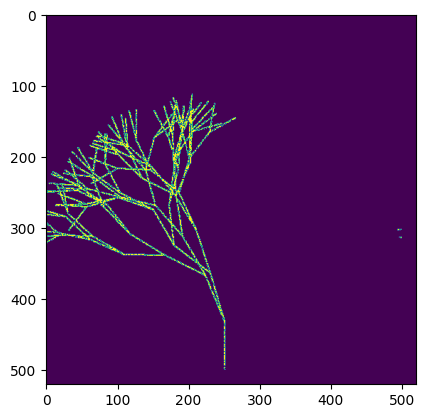

In [ ]:
rows, cols = 520, 520
image = createBranchingTree(width=rows, height=cols, lineWidth=2)
binary = image < threshold_func(image) ## this can be replaced by any binary image
binary = binary[10:-10, 10:-10]
locs = binary2locs(binary, 0.8)
generated_locs = np.zeros_like(binary)
generated_locs[locs] = 1

plt.imshow(generated_locs)

## Set simulation parameters:

In [ ]:
# Camera settings:
ADC_per_photon_conversion = 1.0
ReadOutNoise_ADC = 50
ADC_offset =  100

# Acquisition settings:
emitter_density =  1
number_of_frames =  1000
exposure_time = 0.05
NA =  1.4
wavelength =  600
wavelength_std =  50

# Dynamics settings:
velocity = 0.00 # Set to zero to simulate no motion
bounce_off_walls = True
n_photons =  5000
n_photons_std =  50
blinking_enabled = True
p_off = 0.5
p_on = 0.3
p_bleach = 0.2
bleaching_enabled = False
bleach_rate =  5
blinking_enabled = True
p_off = 0.675
p_on = 0.275
p_bleach = 0.05
n_molecules = locs[0].shape[0]
sigma = 0.21*(wavelength/100)/NA
sigma_std = 0.21*(wavelength_std/100)/NA

## Main simulation loop

In [ ]:
np.random.seed(1)
display_upsampling = 8 # used to display the loc map here
NoiseFreeImages = np.zeros((number_of_frames, cols, rows))

frames = []
all_xloc = []
all_yloc = []
all_photons = []
all_sigmas = []

# Ensure the parameters make sense
assert p_on + p_off + p_bleach == 1.0, "Transition probabilities must sum to 1."

# Generate single molecule emission traces
I_traces = np.zeros((n_molecules, number_of_frames))
state = {0: 0, 1: 1, 2: 0}  # 0: OFF, 1: ON, 2: Bleached

# Define the Markov transition matrix (rows should sum to 1)
Markov = np.array([
    [1 - p_on - p_bleach, p_on, p_bleach],  # From OFF state
    [p_off, 1 - p_off, 0.0],               # From ON state
    [0.0, 0.0, 1.0]                        # From Bleached state (absorbing state)
])

start_state = 0  # Start in OFF state

for m in tqdm(range(n_molecules)):
    if blinking_enabled:
        curr_state = start_state
        for f in range(number_of_frames):
            curr_state = np.random.choice([0, 1, 2], p=Markov[curr_state])
            I_traces[m, f] = state[curr_state]
    else:
        I_traces[m, :] = 1

x_c = locs[1]
y_c = locs[0]

# generate localization positions
for f in tqdm(range(number_of_frames)):
  theta = np.random.uniform(low=0.0, high=2*math.pi, size=n_molecules)
  photon_array = np.random.normal(n_photons, n_photons_std, size=n_molecules)*I_traces[:,f]
  sigma_array = np.random.normal(sigma, sigma_std, size=n_molecules)

  # Build Noise Free image
  tmp = FromLoc2Image_MultiThreaded(x_c, y_c, photon_array, sigma_array, cols, rows)
  NoiseFreeImages[f] = tmp

# Build Noisy Image
Images = ADC_per_photon_conversion * np.random.poisson(NoiseFreeImages) + ReadOutNoise_ADC * np.random.normal(size = (number_of_frames, cols, rows)) + ADC_offset
# Convert to 16-bit
Images[Images > 65535] = 65535
Images[Images <= 0] = 0
Images = Images.astype(np.uint16)

  1%|          | 83/8623 [00:00<01:03, 133.88it/s]

## Display Simulation

In [ ]:
# Interactively display the results using Widgets
def scroll_in_time(frame):
  f = plt.figure(figsize=(18,6))
  plt.subplot(1,3,1)
  plt.imshow(generated_locs, interpolation='bilinear', vmin = 0, vmax=0.1)
  plt.title('Localization image')
  plt.axis('off');

  plt.subplot(1,3,2)
  plt.imshow(NoiseFreeImages[frame-1], interpolation='nearest')
  plt.title('Noise-free simulation')
  plt.axis('off');

  plt.subplot(1,3,3)
  plt.imshow(Images[frame-1], interpolation='nearest')
  plt.title('Noisy simulation')
  plt.axis('off');

widgets.interact(scroll_in_time, frame=widgets.IntSlider(min=1, max=Images.shape[0], step=1, value=0, continuous_update=False));

interactive(children=(IntSlider(value=1, continuous_update=False, description='frame', max=2000, min=1), Outpu…

## Perform eSRRF Parameter Sweep

In [ ]:
sensitivities = [1, 2, 3]
radii = [0.5, 1, 1.5]
magnification = 4

sens, rad = run_esrrf_parameter_sweep(Images[0:100], magnification=magnification, sensitivities=sensitivities, radii=radii, temporal_correlation="AVG", plot_sweep=False, return_qnr=False)

Parameters pairs:   0%|          | 0/9 [00:00<?, ?pairs/s]

Querying the Agent...
Agent chose: opencl
Found:  Buffer size is larger than device maximum memory allocation size
Reducing maximum buffer size and trying again...
Found:  Buffer size is larger than device maximum memory allocation size
Reducing maximum buffer size and trying again...
Agent: eSRRF_ST using opencl ran in 106.00047179195099 seconds


## Generate eSRRF image

Agent: eSRRF_ST using threaded ran in 113.66926024993882 seconds


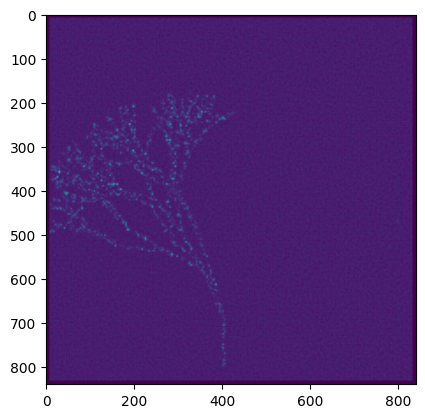

In [ ]:
esrrf_img = eSRRF(Images, magnification=magnification, radius=rad, sensitivity=sens, doIntensityWeighting=True)[0]
temporal_projection = calculate_eSRRF_temporal_correlations(esrrf_img, "AVG")
plt.imshow(temporal_projection)

## Calculate Error Map

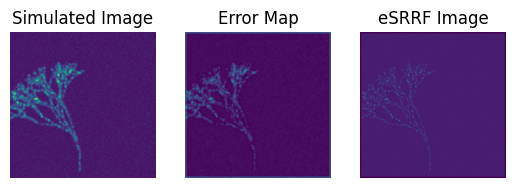

In [ ]:
error_map, rse, rsp = calculate_error_map(np.mean(Images, axis=0), temporal_projection)

plt.subplot(1,3,1)
plt.imshow(np.mean(Images, axis=0))
plt.title("Simulated Image")
plt.axis('off');

plt.subplot(1,3,2)
plt.imshow(error_map)
plt.title('Error Map')
plt.axis('off');

plt.subplot(1,3,3)
plt.imshow(temporal_projection)
plt.title('eSRRF Image')
plt.axis('off');